<a href="https://colab.research.google.com/github/BrunoMoss/BI-Master/blob/main/Trabalho_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalação de bibliotecas

In [1]:
!pip install deap
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 16.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 70.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp311-cp311-linux_x86_64.whl size=886576 sha256=e75188d035db3966f901c08c68f77a07b5fa269564a6a3fa38aa7a2258843bff
  Stored in directory: /root/.cache/pip/wheels/ff/6c/15/506e25bc390de450a7fa53c155cd9b0fbd13ad3e84a9abc183
Successfully built peewee


In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import random
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import math
import requests
import json
plt.style.use("dark_background")


## Carregamento de dados

In [3]:
# Acessa os 100 mais negociados ETF's no mercado americano

url = "https://www.etfcentral.com/search-api/search_v2/_/ju=232/nyseTicker,label,exposure_description,nyseTraded,usd_flow1m,usd_perf1m,shareVol1m,usd_aum,expense_ratio,ttmDividendYield/default/0/100"

payload = {}
headers = {}

response = requests.request("GET", url, headers=headers, data=payload)

data = json.loads(response.text)

tickers = [item['nyseTicker'] for item in data['results']['docs']]

In [4]:
# Seleciona os 50 mais negociados
tickers = tickers[:50]
#tickers.remove('IBIT')

In [5]:
# prompt: salvar a lista tickers em um csv no meu  drive
from google.colab import drive
drive.mount('/content/drive')

# Salva a lista de tickers em um arquivo CSV no Google Drive
file_path = f'/content/drive/My Drive/tickers_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'  # Substitua pelo caminho desejado no seu Google Drive
pd.DataFrame({'Tickers': tickers}).to_csv(file_path, index=False)

Mounted at /content/drive


## Estudo de caso

In [6]:
# Essa função retorna em um DataFrame os preços de fechamento ajustados

df = yf.download(tickers,
              start = '2024-01-01', end = '2024-10-01')['Close']


# Função do pandas para calcular os retornos diários
# dropna é para remover a primeira linha que vai ser nula
df.bfill(inplace=True)
df = df.pct_change().dropna()

[                       0%                       ]WARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**                     4%                       ]  2 of 50 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[***********           22%                       ]  11 of 50 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 8
[*************         28%                       ]  14 of 50 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**********************52%                       ]  26 of 50 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*********************

In [7]:
df.head()

Ticker,AGG,BND,BNDX,EFA,GLD,IBIT,IEFA,IEMG,IJH,IJR,...,VTI,VTV,VUG,VV,VWO,VXUS,VYM,XLF,XLK,XLV
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-03,0.000506,0.000820,0.003050,-0.007516,-0.008337,0.0,-0.008192,-0.004805,-0.022624,-0.026641,...,-0.009591,-0.006249,-0.010112,-0.008107,-0.002954,-0.006283,-0.006051,-0.008474,-0.010190,-0.001657
2024-01-04,-0.004047,-0.004502,-0.006082,0.002299,0.001005,0.0,0.002608,-0.002816,-0.001815,-0.002098,...,-0.002571,-0.001003,-0.004760,-0.003297,-0.001728,0.000527,-0.000896,0.004006,-0.007330,0.004980
2024-01-05,-0.002337,-0.003015,-0.002447,0.000674,0.000158,0.0,0.000144,0.002219,0.003636,-0.002389,...,0.001504,0.001942,0.001129,0.001864,0.001484,0.000702,0.002509,0.004257,-0.000272,-0.000862
2024-01-08,0.003768,0.004398,0.001840,0.010651,-0.007816,0.0,0.010983,0.002818,0.012532,0.016189,...,0.014284,0.006684,0.021102,0.014092,0.001729,0.008244,0.005632,0.006358,0.025092,0.008841
2024-01-09,-0.000203,-0.000137,-0.000816,-0.008938,0.000319,0.0,-0.008290,-0.013850,-0.006426,-0.011218,...,-0.001861,-0.005577,0.002177,-0.001926,-0.011588,-0.009743,-0.006400,-0.006317,0.001589,-0.000142


### Classe com otimizador

In [8]:
class OtimizadorPortfolio:

    def __init__(self, alpha, days,lbda,nr_assets,vl_var_min,vl_var_max,min_weight):
        """
        Inicializa uma instância da classe OtimizadorPortfolio.

        Args:
            alpha (float): Nível de significância do Var paramétrico
            days (int): Base de cálculo das medidas.
            lbda (float): Lambda, fator de decaimento para EWMA.
            nr_assets (int): Número de ativos no portfólio.
            vl_var_min (float): Var mínimo do portfólio.
            vl_var_max (float): Var máximo do portfólio.
            min_weight (float): Peso mínimo dos ativos no portfólio.

        """
        self.alpha = alpha
        self.days = days
        self.lbda = lbda
        self.alpha = alpha
        self.nr_assets = nr_assets
        self.vl_var_min = vl_var_min
        self.vl_var_max = vl_var_max
        self.min_weight = min_weight
        self.df_rets = None

    def set_returns(self, df_rets):
        self.df_rets = df_rets

    def __EWMA_Volatility(self,rets):
      """
      Calcula a volatilidade EWMA de uma série.

      Args:
          rets (DataFrame): Retornos diários.
      Returns:
          float: Volatilidade EWMA.
      """

      sq_rets_sp500 = (rets**2).values
      EWMA_var = np.zeros(len(sq_rets_sp500))

      for r in range(1, len(sq_rets_sp500)):
          EWMA_var[r] = (1-self.lbda)*sq_rets_sp500[r] + self.lbda*EWMA_var[r-1]

      EWMA_vol = np.sqrt(EWMA_var)
      return EWMA_vol[-1]

    def calc_port_vol(self,df_rets,weights,days,ewma=True):
      """
      Calcula a volatilidade de um portfolio.

      Args:
          df_rets(DataFrame): Retornos diários dos ativos que compõem o portfolio.
          weights (list): Pesos dos ativos no portfólio.
          days (int): Base de cálculo das medidas.
          ewma (bool): Indica se o EWMA deve ser utilizado.
      Returns:
          float: Volatilidade do portfolio.
      """
      if ewma:
        ewma_vols = np.array([self.__EWMA_Volatility(df_rets[c]) for c in df_rets.columns])
        matriz_correl = np.corrcoef(df_rets.T.values)
        cov = np.outer(ewma_vols, ewma_vols) * matriz_correl
      else:
        cov = df_rets.cov()
      # Calcula a volatilidade do portfolio
      portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
      return portfolio_vol

    def calc_portfolio_perf_VaR(self,weights,df_rets,days):
        """
        Calcula o retorno, volatilidade e VaR de um portfolio.

        Args:
            weights (list): Pesos dos ativos no portfólio.
            df_rets(DataFrame): Retornos diários dos ativos que compõem o portfolio.
            days (int): Base de cálculo das medidas.
        Returns:
            float: Retorno do portfolio.
            float: Volatilidade do portfolio.
            float: VaR do portfolio.
        """
        weights = np.array(weights)
        mean_returns = df_rets.mean()
        portfolio_return = np.sum(mean_returns * weights) * days
        portfolio_vol = self.calc_port_vol(df_rets,weights,days)
        portfolio_var = abs(portfolio_return - (portfolio_vol * norm.ppf(1 - self.alpha)))
        return portfolio_return, portfolio_vol, portfolio_var

    def __evaluate_function(self,individual):
      """
      Função de que será maximizada
      """

      weights = np.array(individual)
      weights = weights / np.sum(weights)
      ret =  self.calc_portfolio_perf_VaR(weights,self.df_rets,self.days)[0]
      return ret,

    def __create_individuals(self,icls, random_function):
      """
      Função para criar os indivíduos
      """
      i = 0
      cromossomo = list()
      for _ in range(len(self.df_rets.columns)):
        cromossomo.append(random_function())
      return icls(cromossomo)

    def __count_not_equal_zero(self,arr):
      """
      Funções para a restrição do número de ativos no portfólio
      """
      # Arredonda cada elemento do array para a quarta casa decimal
      rounded_arr = [round(num, 4) for num in arr]

      # Conta quantos elementos arredondados são iguais a zero
      zero_count = sum(1 for num in rounded_arr if num == 0)

      # Retorna número de items diferente de zero
      return len(arr) - zero_count

    def __count_items_in_range(self,array, k):
      """
      Funções para a restrição do peso dos ativos no portfólio
      """
      return sum(1 for item in array if 0 < item < k)

    def __penalizeVar(self,x, lower_bound, upper_bound):
      """
      Função de penalização para a restrição do VaR
      """
      if x < lower_bound:
          return lower_bound - x
      elif x > upper_bound:
          return x - upper_bound
      else:
          return 0

    def __feasible_func(self,individual):
      """
      Função que verifica se o indivíduo obedece as restrições de intervalo de VaR, número de ativos e peso mínimo.
      """
      weights = np.array(individual)
      weights = weights / np.sum(weights)
      var =  self.calc_portfolio_perf_VaR(weights,self.df_rets,self.days)[2]
      return self.__count_not_equal_zero(individual) == self.nr_assets and self.__count_items_in_range(weights,self.min_weight) == 0 and (self.vl_var_min < var < self.vl_var_max)

    def ___distance(self,individual):
      """
      Função distância
      """
      weights = np.array(individual)
      weights = weights / np.sum(weights)
      penalty_weights = self.__count_items_in_range(weights,self.min_weight)
      penalty_assets = abs(self.__count_not_equal_zero(weights) -self.nr_assets)
      var = self.calc_portfolio_perf_VaR(weights,self.df_rets,self.days)[2]
      penalty_var = self.__penalizeVar(var,self.vl_var_min,self.vl_var_max)
      return var + (penalty_weights + penalty_assets + penalty_var)*10

    def run_optimization(self,population,nr_ger):
      """
      Função para rodar a otimização
      """
      creator.create("FitnessMax", base.Fitness, weights=(1.0,))
      creator.create("Individual", list, fitness=creator.FitnessMax)

      toolbox = base.Toolbox()
      # Definir o gerador de numeros aleatórios de numeros inteiros entre o intervalo (0 e 1000000)
      toolbox.register("random_int", random.randint, 0, 1000000)
      # Inicialização do cromossomo (quantos genes o cromossomo deve possuir)
      toolbox.register("individual", self.__create_individuals, creator.Individual, toolbox.random_int)
      # Registro do individuo na população
      toolbox.register("population", tools.initRepeat, list, toolbox.individual)
      # Registro do nome da função objetivo
      toolbox.register("evaluate",self.__evaluate_function)
      # Registro da função de penalidade caso o individuo não obedeça as restrições
      toolbox.decorate("evaluate", tools.DeltaPenalty(self.__feasible_func, 0, self.___distance))
      # Registro de qual o tipo de cruzamento deve ser utilizado (cruzamento de 2 pontos)
      toolbox.register("mate", tools.cxTwoPoint)
      # Registro de qual tipo de mutação deve ser utilizado (probabilidade de um individuo sofrer mutação)
      toolbox.register("mutate", tools.mutFlipBit, indpb=0.3)
      # Registro de qual o tipo do método de seleção que será utilizado
      toolbox.register("select", tools.selTournament, tournsize=10)

      pop = toolbox.population(n=population)                   # inicialização da pop
      hof = tools.HallOfFame(1)                                # melhor indivíduo
      stats = tools.Statistics(lambda ind: ind.fitness.values) # estatísticas
      stats.register("avg", np.mean)
      stats.register("std", np.std)
      stats.register("min", np.min)
      stats.register("max", np.max)
      hof.clear()

      pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.85, mutpb=0.5, ngen=nr_ger, stats=stats, halloffame=hof, verbose=True)

      return hof


### Definição de parâmetros do modelo
O portfolio será criado com base nos dados dos 50 ativos mais negociados.
Ele deverá ter um VaR mínimo de 1.1% e um VaR máximo de 1.2%.
Deverá ser composto por no máximo 5 ativos e cada ativo deverá ter um peso mínimo de 5%.

In [9]:
alpha = 0.95
days = 1
lbda = 0.94
nr_assets = 5
vl_var_min = 0.01  # 1.1%
vl_var_max = 0.012 # 1.2%
min_weight = 0.05  # 5%
optm = OtimizadorPortfolio(alpha,days,lbda,nr_assets,vl_var_min,vl_var_max,min_weight)

In [10]:
optm.set_returns(df)
hof = optm.run_optimization(2000,30)

gen	nevals	avg     	std   	min     	max     
0  	2000  	-949.349	2.7556	-950.041	-910.019
1  	1846  	-770.23 	182.301	-950.038	-340.014
2  	1844  	-430.498	107.26 	-950.025	-130.024
3  	1838  	-260.191	55.5956	-500.025	-100.06 
4  	1856  	-187.93 	37.978 	-320.038	-60.0104
5  	1849  	-157.391	40.6724	-290.01 	-40.0222
6  	1850  	-137.648	46.5416	-370.021	-20.0281
7  	1827  	-120.5  	53.1703	-260.095	-20.0281
8  	1840  	-113.181	60.0121	-270.043	-10.0107
9  	1816  	-102.699	64.1979	-270.055	0.000789173
10 	1858  	-95.6673	68.7533	-260.076	0.000874704
11 	1850  	-85.5066	70.7816	-260.077	0.000954047
12 	1831  	-81.9599	73.0415	-250.039	0.00110459 
13 	1868  	-83.0624	75.136 	-290.048	0.00110459 
14 	1855  	-77.8128	76.329 	-260.221	0.00110459 
15 	1860  	-80.2485	76.2125	-260.011	0.00112751 
16 	1833  	-76.4456	74.9471	-240.032	0.00112751 
17 	1867  	-78.6946	76.7144	-260.024	0.00112751 
18 	1862  	-76.893 	76.2834	-260.036	0.0011559  
19 	1849  	-76.7875	75.2921	-250.018	0.00115902 
20 

In [11]:
print("Melhor Indivíduo:")
weights = np.array(hof[0])/np.sum(hof[0])
print(weights)

Melhor Indivíduo:
[0.         0.         0.         0.         0.30547076 0.
 0.         0.         0.         0.         0.         0.
 0.2107309  0.         0.         0.         0.         0.
 0.18622548 0.         0.         0.         0.21353428 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.08403859 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [12]:
best_result = optm.calc_portfolio_perf_VaR(weights,df,1)
print(f"Return: {best_result[0]:%}")
print(f"Vol: {best_result[1]:%}")
print(f"VaR: {best_result[2]:%}")

Return: 0.116972%
Vol: 0.641121%
VaR: 1.171523%


In [13]:
sum(weights)

1.0

### Simulação de 1000 portfólios com pesos aleatórios

In [14]:
import pandas as pd
def simulate_random_portfolios_VaR(num_portfolios,df, alpha, days,nr_assets):
    results_matrix = np.zeros((len(df.columns)+3, num_portfolios))
    for i in range(num_portfolios):
        non_zeros = np.random.random(nr_assets)
        zeros = np.zeros(len(df.columns)-nr_assets)
           # Combinar os dois arrays
        combined_array = np.concatenate((zeros, non_zeros))
        # Embaralhar o array combinado
        np.random.shuffle(combined_array)
        weights =combined_array/ np.sum(combined_array)
        portfolio_return, portfolio_std, portfolio_VaR = optm.calc_portfolio_perf_VaR(weights, df, days)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]

    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])

    return results_df

In [15]:
num_portfolios = 1000
results_frame = simulate_random_portfolios_VaR(num_portfolios, df, alpha, days,nr_assets)
best_result = optm.calc_portfolio_perf_VaR(weights,df,days)

No gráfico abaixo podemos verificar o ponto azul que é o ponto de menor valor Retono x Var gerado a partir dos pesos aleatórios. O ponto em vermelho foi gerado através do modelo de otimização e mostra a maximização do retorno para uma faixa de VaR atribuída.

<ipython-input-16-12874380f0c5>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='b',s=100)


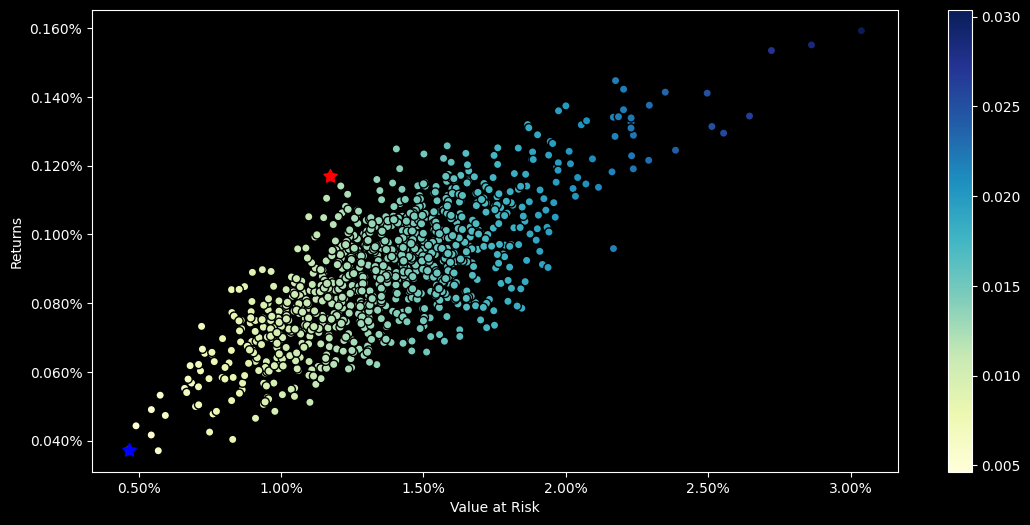

In [16]:
import matplotlib.ticker as mtick
#locate position of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
fig, ax = plt.subplots(figsize=(13,6))
plt.scatter(results_frame.VaR,results_frame.ret,c=results_frame.VaR,edgecolors="black",cmap='YlGnBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()

# Formatar o eixo x como percentual
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# Formatar o eixo y como percentual
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
#plot blue star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='b',s=100)
plt.scatter(best_result[2],best_result[0],marker=(5,1,0),color='r',s=100)
plt.show()

### Definição de um benchark

Foi definido um benchmark (S&P 100) para comparação do desempenho do portfolio

In [17]:
bench = '^OEX'

In [18]:
df_bench = yf.download(bench,
               start = '2024-01-01', end = '2024-10-01')['Close']
df_bench = df_bench.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


### Comparação dos resultados do portfolio gerado com o benchmark

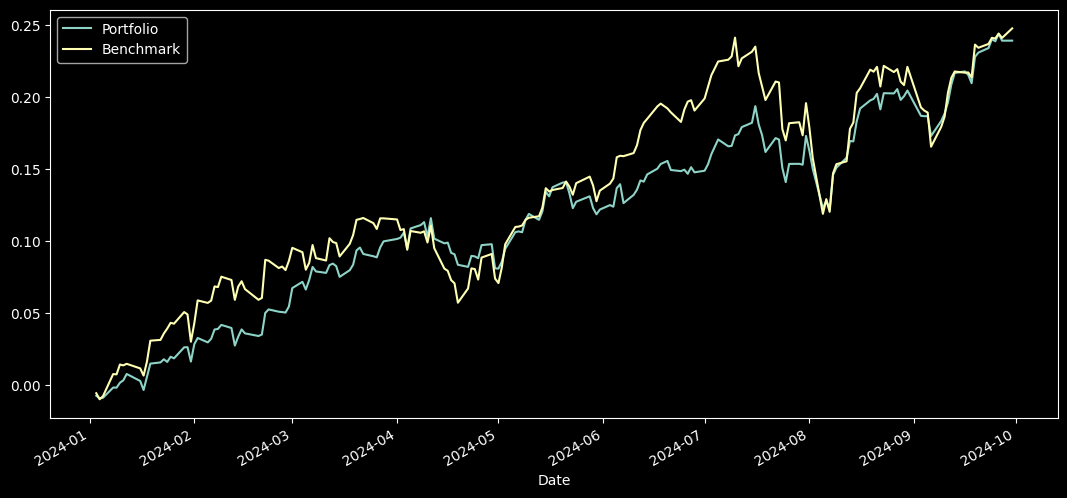

In [19]:
# Calculate the weighted stock returns
WeightedReturns = df*weights

# Calculate the weighted stock returns
portfolioReturns= WeightedReturns.sum(axis=1)

# Plot the cumulative portfolio returns over time
CumulativeReturns = ((1+portfolioReturns).cumprod()-1)
CumulativeReturnsBench = ((1+df_bench).cumprod()-1)
df_perf_compare = pd.DataFrame({'Portfolio':CumulativeReturns,'Benchmark':CumulativeReturnsBench.squeeze()})
df_perf_compare.plot(figsize=(13,6))
plt.show()

In [20]:
best_result = optm.calc_portfolio_perf_VaR([1.0],df_bench,1)
print(f"Return: {best_result[0]:%}")
print(f"Vol Ewma: {best_result[1]:%}")
print(f"VaR: {best_result[2]:%}")
print(f"Sharpe Ratio: {best_result[0]/optm.calc_port_vol(df_bench,np.array([1.0]),1,False):%}")

Return: 0.122347%
Vol Ewma: 0.908651%
VaR: 1.616945%
Sharpe Ratio: 13.865655%


In [21]:
best_result = optm.calc_portfolio_perf_VaR(weights,df,1)
print(f"Return: {best_result[0]:%}")
print(f"Vol Ewma: {best_result[1]:%}")
print(f"VaR: {best_result[2]:%}")
print(f"Sharpe Ratio: {best_result[0]/optm.calc_port_vol(df,weights,1,ewma=False):%}")

Return: 0.116972%
Vol Ewma: 0.641121%
VaR: 1.171523%
Sharpe Ratio: 17.727354%


O sharpe gerado pelo portifolio foi maior do que o gerado pelo benckmark

## Estudo para implementação de ferramenta de geração de portfolios

In [23]:
df_test = yf.download(tickers,
              start = '2024-01-01', end = '2024-10-31')['Close']


# Função do pandas para calcular os retornos diários
# dropna é para remover a primeira linha que vai ser nula
df_test.bfill(inplace=True)
df_test = df_test.pct_change().dropna()


[*********************100%***********************]  50 of 50 completed


In [24]:
df_bench_test = yf.download(bench,
              start = '2024-01-01', end = '2024-10-31')['Close']

#01/01/2024 - 01/11/2024
# Função do pandas para calcular os retornos diários
# dropna é para remover a primeira linha que vai ser nula
df_bench_test.bfill(inplace=True)
df_bench_test = df_bench_test.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [25]:
df_test

Ticker,AGG,BND,BNDX,EFA,GLD,IBIT,IEFA,IEMG,IJH,IJR,...,VTI,VTV,VUG,VV,VWO,VXUS,VYM,XLF,XLK,XLV
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-03,0.000506,0.000819,0.003050,-0.007516,-0.008337,0.000000,-0.008192,-0.004805,-0.022624,-0.026641,...,-0.009591,-0.006249,-0.010112,-0.008107,-0.002954,-0.006283,-0.006052,-0.008475,-0.010190,-0.001657
2024-01-04,-0.004047,-0.004502,-0.006081,0.002299,0.001005,0.000000,0.002608,-0.002816,-0.001815,-0.002098,...,-0.002571,-0.001003,-0.004761,-0.003297,-0.001728,0.000527,-0.000895,0.004006,-0.007330,0.004980
2024-01-05,-0.002337,-0.003015,-0.002448,0.000675,0.000158,0.000000,0.000144,0.002219,0.003636,-0.002389,...,0.001504,0.001942,0.001130,0.001864,0.001484,0.000702,0.002509,0.004257,-0.000272,-0.000862
2024-01-08,0.003768,0.004399,0.001840,0.010651,-0.007816,0.000000,0.010983,0.002818,0.012532,0.016189,...,0.014284,0.006683,0.021102,0.014092,0.001729,0.008244,0.005632,0.006358,0.025092,0.008841
2024-01-09,-0.000203,-0.000137,-0.000816,-0.008938,0.000319,0.000000,-0.008290,-0.013850,-0.006426,-0.011218,...,-0.001861,-0.005577,0.002177,-0.001926,-0.011588,-0.009742,-0.006400,-0.006317,0.001589,-0.000142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,0.001927,0.001639,0.001803,0.005646,0.007693,0.028035,0.005658,-0.002124,0.001604,0.002791,...,0.002666,-0.003420,0.006700,0.003017,-0.001061,0.002083,-0.001850,0.000849,0.002933,-0.006582
2024-10-25,-0.002024,-0.002046,-0.000800,-0.003369,0.002057,-0.022125,-0.003349,-0.001064,-0.005444,-0.004436,...,-0.000945,-0.007034,0.004633,-0.000714,-0.000850,-0.002718,-0.008109,-0.011029,0.005194,-0.005488
2024-10-28,-0.001623,-0.001230,0.001200,0.008012,0.000039,0.043673,0.007527,0.003550,0.009981,0.015113,...,0.004062,0.005471,0.001656,0.002934,0.003189,0.006733,0.006774,0.012438,-0.000304,0.001481


In [26]:
# Função para dado uma janela temporal de x meses gerar uma lista com uma janela de n meses consecutivos e m meses posteriores a esses n meses.
# Cada item da lista de retorno representa uma nova janela ao avançar mês a mês nos x meses.
def create_subseries(df,n_train,m_test):
  """
  Função para dado uma janela temporal de x meses gerar uma lista com uma janela de n meses consecutivos e m meses posteriores a esses n meses.
  Args:
      df(DataFrame): dataframe com  série que será utilizada para gerarmos os dados de treino e teste.
      n_train(int): número de meses que serão utilizados para gerar os dados de treino.
      m_test(int): número de meses que serão utilizados para gerar os dados de teste.
  Returns:
      list: lista com os dados de treino e teste.

  """

  if isinstance(df, pd.Series):
    df = df.to_frame()

  # Extrair o mês e o ano
  df['ano_mes'] = df.index.to_period('M')

  # Agrupar por ano e mês
  grouped = df.groupby('ano_mes')

  # Criar a lista de subseries
  subseries = [group.drop('ano_mes',axis=1) for _, group in grouped]

  splited_subseries = []
  for i in range(len(subseries)-n_train-m_test+1):
    splited_subseries.append ((pd.concat(subseries[i:n_train+i]),pd.concat(subseries[i+n_train:i+n_train+m_test])))

  return splited_subseries


Será gerado uma amostra com 4 meses para treino e geração dos pesos dos portfolios e 1 mês para o teste desses pesos contra o benchmark.
A cada ciclo os pesos são regerados com base nos dados dos últimos 4 meses e confrontados contra o resultado do benckmark do próximo mês.

In [27]:
data_test = create_subseries(df_test,4,1)

In [28]:
data_bench_test = create_subseries(df_bench_test,4,1)

### Treinamento e geração dos pesos dos portfolios

A cada ciclo treino são armazenados os pesos gerados junto com algumas métricas referente a comparação dos resultados dos porfolios e do benchmark para os dados de treino.

In [29]:
import warnings
warnings.filterwarnings(action='once')
df_results = pd.DataFrame(columns=['period','weights','vol_port','vol_bench','rent_port','rent_bench','sharp_port','sharp_bench'])
for i in range(len(data_test)):
  print(f'Iteração nr {i}')
  optm.set_returns(data_test[i][0])
  hof = optm.run_optimization(1500,20)
  w = np.array(hof[0])/np.sum(hof[0])
  best_result = optm.calc_portfolio_perf_VaR(w,data_test[i][0],1)
  sharpe_port = best_result[0]/optm.calc_port_vol(data_test[i][0],w,1,ewma=False)
  best_result_bench = optm.calc_portfolio_perf_VaR([1.0],data_bench_test[i][0],1)
  sharpe_bench = best_result_bench[0]/optm.calc_port_vol(data_bench_test[i][0],np.array([1.0]),1,False)
  df_results.loc[i] = [i,w,best_result[1],best_result_bench[1],best_result[0],best_result_bench[0],sharpe_port,sharpe_bench]
df_results.to_json(f'/content/drive/My Drive/resultados_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json', orient='records', lines=True)

Iteração nr 0


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	std    	min     	max     
0  	1500  	-949.473	2.28952	-950.025	-930.012
1  	1411  	-773.519	183.496	-950.017	-330.016
2  	1387  	-423.134	104.274	-740.011	-190.012
3  	1386  	-255.217	50.9285	-470.011	-120.011
4  	1369  	-189.467	35.3379	-310.019	-100.011
5  	1376  	-163.937	40.3859	-410.011	-50.0671
6  	1397  	-144.372	46.8009	-390.012	-40.0299
7  	1409  	-130.093	54.0749	-390.021	-20.0115
8  	1416  	-117.027	59.6279	-390.022	-10.0111
9  	1383  	-106.906	64.3622	-390.03 	-10.0116
10 	1403  	-95.8569	65.4374	-260.103	0.000518475
11 	1379  	-82.9428	70.141 	-320.04 	0.000688563
12 	1409  	-82.9013	73.5457	-270.021	0.000688563
13 	1392  	-78.0793	75.2798	-250.048	0.000750592
14 	1364  	-75.6639	76.2684	-250.04 	0.000720327
15 	1380  	-77.1576	76.2497	-280.069	0.000727514
16 	1391  	-77.5288	76.7421	-260.023	0.000783279
17 	1390  	-78.9434	75.5342	-280.032	0.00083875 
18 	1402  	-73.6016	76.9937	-260.011	0.00083875 
19 	1407  	-75.6725	77.4503	-250.037	0.00083875 
20 	

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	std    	min     	max     
0  	1500  	-949.285	2.72125	-950.016	-930.011
1  	1398  	-777.278	179.47 	-950.012	-320.013
2  	1375  	-430.698	108.656	-940.011	-170.01 
3  	1384  	-257.3  	53.9732	-460.01 	-100.01 
4  	1398  	-187.503	37.2061	-300.017	-70.0116
5  	1384  	-157.204	40.0407	-300.012	-50.0117
6  	1374  	-139.692	49.0317	-510.011	-30.0127
7  	1381  	-123.913	53.491 	-280.101	-30.0109
8  	1399  	-112.442	59.0662	-260.101	-10.0188
9  	1389  	-103.848	64.5545	-340.023	-10.0105
10 	1391  	-96.2612	70.6408	-450.011	0.00102756
11 	1397  	-92.1808	72.1894	-260.017	0.00105085
12 	1375  	-88.8653	74.7556	-370.011	0.00116778
13 	1398  	-82.5643	74.7302	-260.012	0.00121206
14 	1389  	-76.5289	76.9221	-260.04 	0.00124754
15 	1379  	-74.3662	76.491 	-260.035	0.00126119
16 	1394  	-80.3852	75.6085	-250.059	0.001304  
17 	1388  	-77.2783	75.7315	-260.028	0.00131099
18 	1360  	-75.1578	76.5013	-270.084	0.00131514
19 	1399  	-75.0512	75.5173	-270.017	0.00132947
20 	1390  	-75

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	std    	min     	max     
0  	1500  	-949.339	2.74539	-950.027	-920.025
1  	1403  	-773.01 	181.533	-950.024	-360.027
2  	1387  	-433.41 	103.704	-890.011	-180.019
3  	1365  	-262.07 	54.8757	-520.012	-100.028
4  	1393  	-190.911	37.5844	-320.02 	-60.0188
5  	1376  	-159.328	39.3486	-290.016	-50.0107
6  	1411  	-141.776	45.7929	-390.018	-40.0109
7  	1383  	-129.963	54.4989	-410.027	-20.0327
8  	1389  	-118.56 	59.4857	-410.018	-10.0183
9  	1395  	-108.819	65.258 	-450.011	-0.0358221
10 	1388  	-95.2498	67.8876	-260.074	0.000809  
11 	1378  	-88.0153	72.9494	-430.018	0.00101644
12 	1381  	-84.6608	74.1876	-280.054	0.00101644
13 	1391  	-80.3333	74.719 	-250.011	0.00116446
14 	1388  	-85.3794	76.6682	-270.014	0.00116446


<ipython-input-8-dc5a652ede86>:146: RuntimeWarning: invalid value encountered in divide
  weights = weights / np.sum(weights)
<ipython-input-8-dc5a652ede86>:155: RuntimeWarning: invalid value encountered in divide
  weights = weights / np.sum(weights)


15 	1387  	nan     	nan    	nan     	nan       
16 	1390  	-76.5791	75.6804	-260.036	0.00124989
17 	1409  	-80.9588	76.3152	-250.035	0.00124989
18 	1413  	-80.4583	75.928 	-250.011	0.00124989
19 	1376  	-76.9044	76.9861	-250.012	0.00124989
20 	1387  	-79.191 	76.6288	-250.04 	0.00126821
Iteração nr 3


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	std    	min     	max     
0  	1500  	-949.332	2.82768	-950.035	-920.012
1  	1389  	-779.843	180.101	-950.03 	-390.01 
2  	1363  	-431.471	102.844	-850.012	-190.012
3  	1391  	-264.693	52.435 	-460.012	-110.021
4  	1409  	-196.476	36.8036	-350.01 	-90.011 
5  	1385  	-166.031	39.3255	-300.026	-60.0101
6  	1378  	-146.645	45.2064	-370.011	-30.0106
7  	1367  	-132.687	52.8358	-410.022	-20.0137
8  	1392  	-117.946	59.4069	-410.022	-10.0154
9  	1371  	-105.892	65.3647	-410.037	0.000390148
10 	1386  	-99.2779	69.0588	-470.018	0.000725781
11 	1360  	-92.4244	71.6041	-250.044	0.000725781
12 	1381  	-85.5108	74.9201	-280.056	0.000725781
13 	1399  	-77.2023	75.2   	-260.011	0.000761852
14 	1378  	-77.0452	75.9177	-250.027	0.000761852
15 	1384  	-74.6621	76.0303	-250.034	0.000761852
16 	1374  	-75.6927	76.5964	-240.05 	0.000771209
17 	1369  	-77.5721	78.1234	-240.2  	0.000771209
18 	1389  	-76.6385	78.1681	-250.047	0.000771209
19 	1398  	-76.8183	78.8225	-280.045	0.000771209
2

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	std    	min     	max     
0  	1500  	-949.383	2.53587	-950.061	-930.043
1  	1358  	-782.265	181.169	-950.056	-330.065
2  	1386  	-432.947	103.933	-820.041	-150.05 
3  	1373  	-263.303	54.8518	-440.047	-100.018
4  	1395  	-189.213	37.9272	-340.05 	-90.0207
5  	1389  	-158.36 	39.3328	-290.037	-50.032 
6  	1376  	-141.431	47.3226	-370.053	-30.078 
7  	1367  	-127.203	54.1253	-430.047	-10.0631
8  	1411  	-114.879	60.0717	-450.048	-10.0115
9  	1385  	-101.398	64.1924	-430.054	0.000800378
10 	1365  	-92.781 	68.1727	-260.031	0.000975181
11 	1391  	-86.5073	70.7012	-250.053	0.00110045 
12 	1387  	-80.6826	74.4591	-390.051	0.00110045 
13 	1404  	-79.4442	76.0996	-300.068	0.00110045 
14 	1381  	-79.9595	77.5633	-370.023	0.00110045 
15 	1394  	-77.7104	77.1037	-430.05 	0.00117842 
16 	1390  	-79.8228	76.8174	-450.042	0.00124361 
17 	1393  	-77.6828	79.0385	-390.051	0.00124361 
18 	1361  	-78.7083	77.1739	-390.024	0.00124361 
19 	1395  	-78.4871	78.8889	-470.038	0.00124797 
2

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	std    	min     	max     
0  	1500  	-949.372	2.62835	-950.044	-920.014
1  	1381  	-772.667	180.324	-950.034	-330.045
2  	1398  	-430.628	108.094	-730.027	-160.017
3  	1365  	-256.185	51.8633	-450.027	-110.011
4  	1388  	-189.381	36.7927	-330.011	-80.01  
5  	1381  	-162.064	40.2988	-320.057	-50.0101
6  	1381  	-143.136	46.953 	-280.058	-40.0113
7  	1389  	-128.268	53.3453	-290.098	-30.0102
8  	1395  	-115.941	60.8297	-280.057	-10.0117
9  	1400  	-106.198	63.9369	-320.011	-0.0279633
10 	1385  	-95.4371	67.1047	-260.05 	0.00102206
11 	1404  	-87.9363	69.7724	-280.012	0.00108433
12 	1379  	-84.0219	72.8067	-260.031	0.00122445
13 	1384  	-81.1609	75.0224	-230.068	0.00127372
14 	1366  	-75.9318	75.1668	-260.027	0.00127372
15 	1426  	-76.2695	76.0834	-280.048	0.00127372
16 	1376  	-76.7673	76.304 	-260.013	0.00127372
17 	1399  	-77.7527	77.2401	-390.035	0.00127372
18 	1371  	-76.1045	76.9479	-250.036	0.00130081
19 	1398  	-78.5578	76.3051	-240.031	0.00130692
20 	1408  	-

Comparação da rentabilidade acumulada do portfolio x benchmarck nos períodos de treino.

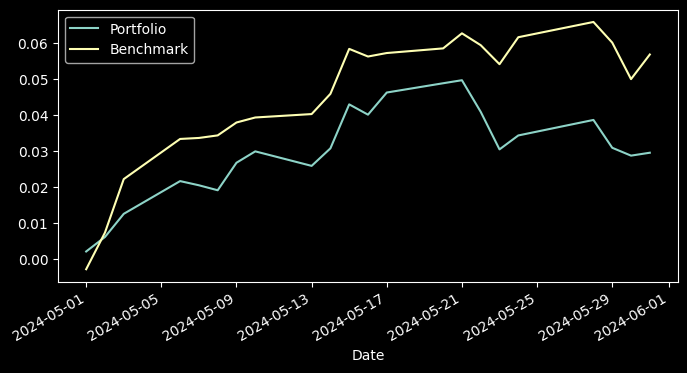

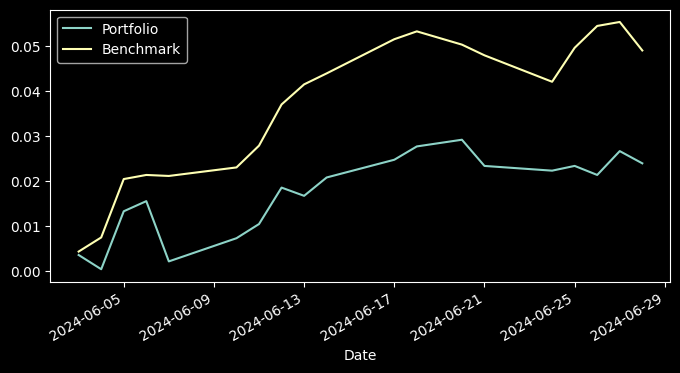

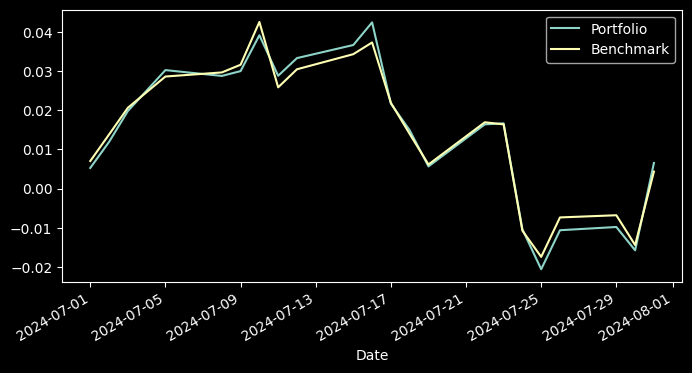

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


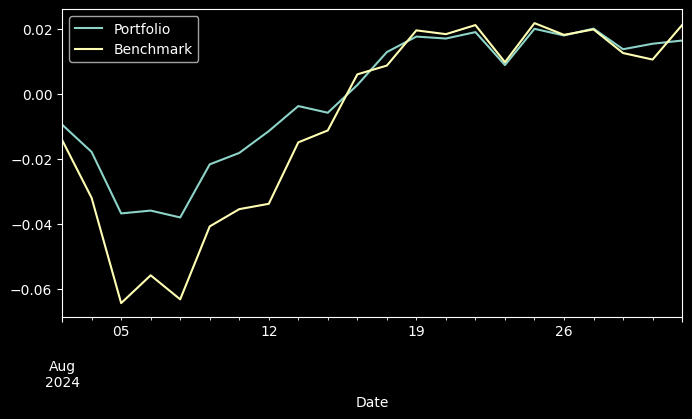

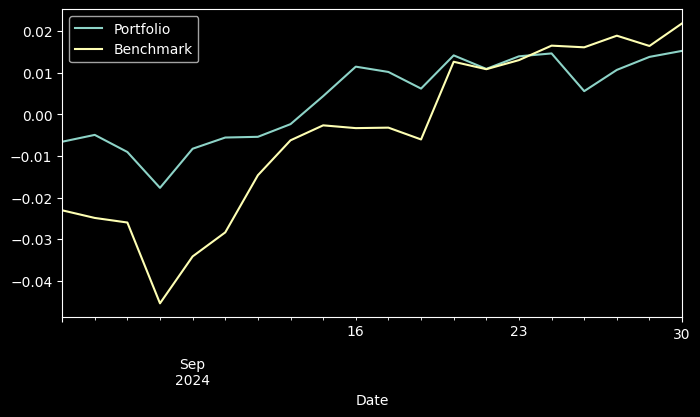

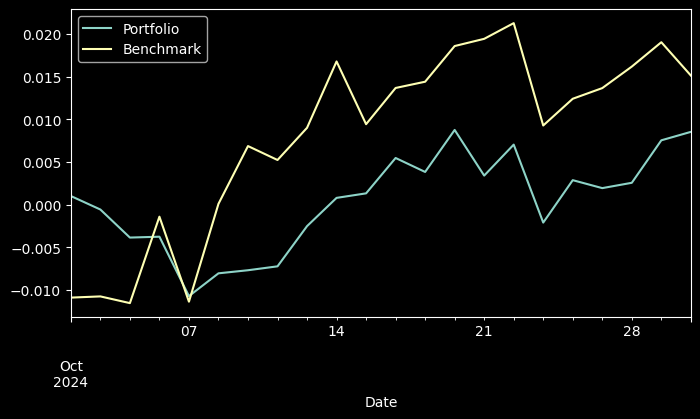

In [30]:
for i in range(len(data_test)):
  # Calculate the weighted stock returns
  WeightedReturns = data_test[i][1]*df_results.loc[i,'weights']
  # Calculate the weighted stock returns
  portfolioReturns= WeightedReturns.sum(axis=1)
  # Plot the cumulative portfolio returns over time
  CumulativeReturns = ((1+portfolioReturns).cumprod()-1)
  CumulativeReturnsBench = ((1+data_bench_test[i][1]).cumprod()-1)
  df_perf_compare = pd.DataFrame({'Portfolio':CumulativeReturns,'Benchmark':CumulativeReturnsBench.squeeze()})
  df_perf_compare.plot(figsize=(8,4))
  plt.show()

### Comparação dos resultados nas amostras de teste

In [31]:
for i in range(len(data_test)):
  w = df_results.loc[i,'weights']

  best_result = optm.calc_portfolio_perf_VaR(w,data_test[i][1],1)
  best_result_bench = optm.calc_portfolio_perf_VaR([1],data_bench_test[i][1],1)
  print(f'Iteração nr {i}')
  print(f"Return Port: {best_result[0]:%}, Return Bench: {best_result_bench[0]:%}")
  print(f"Vol Port EWMA: {best_result[1]:%}, Vol Bench EWMA: {best_result_bench[1]:%}")
  print(f"VaR Port: {best_result[2]:%}, VaR Bench: {best_result_bench[2]:%}")
  print(f"Sharpe Ratio Port: {best_result[0]/optm.calc_port_vol(data_test[i][1],w,1,ewma=False):%}, Sharpe Ratio Bench: {best_result_bench[0]/optm.calc_port_vol(data_bench_test[i][1],np.array([1]),1,ewma=False):%}")

Iteração nr 0
Return Port: 0.133892%, Return Bench: 0.253589%
Vol Port EWMA: 0.483157%, Vol Bench EWMA: 0.534544%
VaR Port: 0.928614%, VaR Bench: 1.132836%
Sharpe Ratio Port: 23.796634%, Sharpe Ratio Bench: 41.473061%
Iteração nr 1
Return Port: 0.125850%, Return Bench: 0.253176%
Vol Port EWMA: 0.431035%, Vol Bench EWMA: 0.422938%
VaR Port: 0.834838%, VaR Bench: 0.948847%
Sharpe Ratio Port: 22.674287%, Sharpe Ratio Bench: 52.826254%
Iteração nr 2
Return Port: 0.035470%, Return Bench: 0.025002%
Vol Port EWMA: 1.018914%, Vol Bench EWMA: 0.964349%
VaR Port: 1.711435%, VaR Bench: 1.611215%
Sharpe Ratio Port: 3.198103%, Sharpe Ratio Bench: 2.359784%
Iteração nr 3
Return Port: 0.076833%, Return Bench: 0.103193%
Vol Port EWMA: 0.605234%, Vol Bench EWMA: 0.941886%
VaR Port: 1.072354%, VaR Bench: 1.652458%
Sharpe Ratio Port: 9.386907%, Sharpe Ratio Bench: 7.836100%
Iteração nr 4
Return Port: 0.077118%, Return Bench: 0.112758%
Vol Port EWMA: 0.394168%, Vol Bench EWMA: 0.619721%
VaR Port: 0.725466

In [32]:
df_results

,period,weights,vol_port,vol_bench,rent_port,rent_bench,sharp_port,sharp_bench
0,0,"[0.0, 0.0, 0.21376003982727593, 0.0, 0.3620130...",0.005979,0.009020,0.000839,0.000904,0.164193,0.110840
1,1,"[0.0, 0.0, 0.0, 0.0, 0.33485074289228783, 0.0,...",0.006485,0.007019,0.001329,0.001186,0.200299,0.150492
2,2,"[0.0, 0.0, 0.0, 0.0, 0.20755317688104688, 0.0,...",0.006436,0.005756,0.001268,0.001131,0.171770,0.158815
3,3,"[0.0, 0.0, 0.0, 0.0, 0.3284671688633771, 0.0, ...",0.006747,0.010107,0.000771,0.000848,0.123659,0.103851
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.006343,0.010856,0.001248,0.001554,0.211162,0.166928
5,5,"[0.0, 0.0, 0.0, 0.0, 0.3125224942698807, 0.0, ...",0.005710,0.009070,0.001307,0.001191,0.200367,0.118671


In [ ]:
#df_results.to_json('/content/drive/My Drive/resultados.json', orient='records', lines=True)

In [33]:
df_results.to_json(f'/content/drive/My Drive/resultados_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json', orient='records', lines=True)